In [44]:
# Version 1.1 released by Yi-Chuan Lu on February 23, 2023.
#    Release 1.1 accommodates old Python 2 installations that
#    interpret some constants as integers instead of reals.
# Version 1.0 released by Yi-Chuan Lu on May 18, 2022.
# 
# When using this code, please cite:
# 
# @article{20heatindex,
#   Title   = {Extending the Heat Index},
#   Author  = {Yi-Chuan Lu and David M. Romps},
#   Journal = {Journal of Applied Meteorology and Climatology},
#   Year    = {2022},
#   Volume  = {61},
#   Number  = {10},
#   Pages   = {1367--1383},
#   Year    = {2022},
# }
#
# This headindex function returns the Heat Index in Kelvin. The inputs are:
# - T, the temperature in Kelvin
# - RH, the relative humidity, which is a value from 0 to 1
# - show_info is an optional logical flag. If true, the function returns the physiological state.

import math

# Thermodynamic parameters
Ttrip = 273.16       # K
ptrip = 611.65       # Pa
E0v   = 2.3740e6     # J/kg
E0s   = 0.3337e6     # J/kg
rgasa = 287.04       # J/kg/K 
rgasv = 461.         # J/kg/K 
cva   = 719.         # J/kg/K
cvv   = 1418.        # J/kg/K 
cvl   = 4119.        # J/kg/K
cvs   = 1861.        # J/kg/K
cpa   = cva + rgasa
cpv   = cvv + rgasv

# The saturation vapor pressure
def pvstar(T):
    if T == 0.0:
        return 0.0
    elif T<Ttrip:
        return ptrip * (T/Ttrip)**((cpv-cvs)/rgasv) * math.exp( (E0v + E0s -(cvv-cvs)*Ttrip)/rgasv * (1./Ttrip - 1./T) )
    else:
        return ptrip * (T/Ttrip)**((cpv-cvl)/rgasv) * math.exp( (E0v       -(cvv-cvl)*Ttrip)/rgasv * (1./Ttrip - 1./T) )

# The latent heat of vaporization of water
def Le(T):
    return (E0v + (cvv-cvl)*(T-Ttrip) + rgasv*T)

# Thermoregulatory parameters
sigma       = 5.67e-8                     # W/m^2/K^4 , Stefan-Boltzmann constant
epsilon     = 0.97                        #           , emissivity of surface, steadman1979
M           = 83.6                        # kg        , mass of average US adults, fryar2018
H           = 1.69                        # m         , height of average US adults, fryar2018
A           = 0.202*(M**0.425)*(H**0.725) # m^2       , DuBois formula, parson2014
cpc         = 3492.                       # J/kg/K    , specific heat capacity of core, gagge1972
C           = M*cpc/A                     #           , heat capacity of core
r           = 124.                        # Pa/K      , Zf/Rf, steadman1979
Q           = 180.                        # W/m^2     , metabolic rate per skin area, steadman1979
phi_salt    = 0.9                         #           , vapor saturation pressure level of saline solution, steadman1979
Tc          = 310.                        # K         , core temperature, steadman1979
Pc          = phi_salt * pvstar(Tc)       #           , core vapor pressure
L           = Le(310.)                    #           , latent heat of vaporization at 310 K
p           = 1.013e5                     # Pa        , atmospheric pressure
eta         = 1.43e-6                     # kg/J      , "inhaled mass" / "metabolic rate", steadman1979
Pa0         = 1.6e3                       # Pa        , reference air vapor pressure in regions III, IV, V, VI, steadman1979

# Thermoregulatory functions
def Qv(Ta,Pa): # respiratory heat loss, W/m^2
    return  eta * Q *(cpa*(Tc-Ta)+L*rgasa/(p*rgasv) * ( Pc-Pa ) )
def Zs(Rs): # mass transfer resistance through skin, Pa m^2/W
    return (52.1 if Rs == 0.0387 else 6.0e8 * Rs**5)
def Ra(Ts,Ta): # heat transfer resistance through air, exposed part of skin, K m^2/W
    hc      = 17.4
    phi_rad = 0.85
    hr      = epsilon * phi_rad * sigma* (Ts**2 + Ta**2)*(Ts + Ta)
    return 1./(hc+hr)
def Ra_bar(Tf,Ta): # heat transfer resistance through air, clothed part of skin, K m^2/W
    hc      = 11.6
    phi_rad = 0.79
    hr      = epsilon * phi_rad * sigma* (Tf**2 + Ta**2)*(Tf + Ta)
    return 1./(hc+hr)
def Ra_un(Ts,Ta): # heat transfer resistance through air, when being naked, K m^2/W
    hc      = 12.3
    phi_rad = 0.80
    hr      = epsilon * phi_rad * sigma* (Ts**2 + Ta**2)*(Ts + Ta)
    return 1./(hc+hr)

Za     = 60.6/17.4  # Pa m^2/W, mass transfer resistance through air, exposed part of skin
Za_bar = 60.6/11.6  # Pa m^2/W, mass transfer resistance through air, clothed part of skin
Za_un  = 60.6/12.3  # Pa m^2/W, mass transfer resistance through air, when being naked

# tolerance and maximum iteration for the root solver 
tol     = 1e-8
tolT    = 1e-8
maxIter = 100

# Given air temperature and relative humidity, returns the equivalent variables 
def find_eqvar(Ta,RH):
    Pa    = RH*pvstar(Ta) #         , air vapor pressure
    Rs    = 0.0387        # m^2K/W  , heat transfer resistance through skin
    phi   = 0.84          #         , covering fraction
    dTcdt = 0.            # K/s     , rate of change in Tc
    m     = (Pc-Pa)/(Zs(Rs)+Za)
    m_bar = (Pc-Pa)/(Zs(Rs)+Za_bar)
    Ts = solve(lambda Ts: (Ts-Ta)/Ra(Ts,Ta)     + (Pc-Pa)/(Zs(Rs)+Za)     - (Tc-Ts)/Rs, max(0.,min(Tc,Ta)-Rs*abs(m)),     max(Tc,Ta)+Rs*abs(m),    tol,maxIter)
    Tf = solve(lambda Tf: (Tf-Ta)/Ra_bar(Tf,Ta) + (Pc-Pa)/(Zs(Rs)+Za_bar) - (Tc-Tf)/Rs, max(0.,min(Tc,Ta)-Rs*abs(m_bar)), max(Tc,Ta)+Rs*abs(m_bar),tol,maxIter)
    flux1 = Q-Qv(Ta,Pa)-(1.-phi)*(Tc-Ts)/Rs                   # C*dTc/dt when Rf=Zf=\inf
    flux2 = Q-Qv(Ta,Pa)-(1.-phi)*(Tc-Ts)/Rs - phi*(Tc-Tf)/Rs  # C*dTc/dt when Rf=Zf=0
    if (flux1 <= 0.) : # region I
        eqvar_name = "phi"
        phi = 1.-(Q-Qv(Ta,Pa))*Rs/(Tc-Ts)
        Rf  = float('inf')
    elif (flux2 <=0.) : # region II&III
        eqvar_name = "Rf"
        Ts_bar = Tc - (Q-Qv(Ta,Pa))*Rs/phi + (1./phi -1.)*(Tc-Ts)
        Tf = solve(lambda Tf: (Tf-Ta)/Ra_bar(Tf,Ta) + (Pc-Pa)*(Tf-Ta)/((Zs(Rs)+Za_bar)*(Tf-Ta)+r*Ra_bar(Tf,Ta)*(Ts_bar-Tf)) - (Tc-Ts_bar)/Rs, Ta,Ts_bar,tol,maxIter)
        Rf = Ra_bar(Tf,Ta)*(Ts_bar-Tf)/(Tf-Ta)
    else: # region IV,V,VI
        Rf = 0.
        flux3 =  Q-Qv(Ta,Pa)-(Tc-Ta)/Ra_un(Tc,Ta)-(phi_salt*pvstar(Tc)-Pa)/Za_un
        if (flux3 < 0.) : # region IV,V
            Ts = solve(lambda Ts: (Ts-Ta)/Ra_un(Ts,Ta)+(Pc-Pa)/(Zs((Tc-Ts)/(Q-Qv(Ta,Pa)))+Za_un)-(Q-Qv(Ta,Pa)),0.,Tc,tol,maxIter)
            Rs = (Tc-Ts)/(Q-Qv(Ta,Pa))
            eqvar_name = "Rs"
            Ps = Pc - (Pc-Pa)* Zs(Rs)/( Zs(Rs)+Za_un)
            if (Ps > phi_salt * pvstar(Ts)):  # region V
                Ts = solve( lambda Ts : (Ts-Ta)/Ra_un(Ts,Ta) + (phi_salt*pvstar(Ts)-Pa)/Za_un -(Q-Qv(Ta,Pa)), 0.,Tc,tol,maxIter)
                Rs = (Tc-Ts)/(Q-Qv(Ta,Pa))
                eqvar_name = "Rs*"
        else: # region VI
            Rs = 0.
            eqvar_name = "dTcdt"
            dTcdt = (1./C)* flux3
    return [eqvar_name,phi,Rf,Rs,dTcdt]

# given the equivalent variable, find the Heat Index
def find_T(eqvar_name,eqvar):
    if (eqvar_name == "phi"):
        T = solve(lambda T: find_eqvar(T,1.)[1]-eqvar,0.,240.,tolT,maxIter)
        region = 'I'
    elif (eqvar_name == "Rf"):
        T = solve(lambda T: find_eqvar(T,min(1.,Pa0/pvstar(T)))[2]-eqvar,230.,300.,tolT,maxIter)
        region = ('II' if Pa0>pvstar(T) else 'III')
    elif (eqvar_name == "Rs" or eqvar_name == "Rs*"):
        T = solve(lambda T: find_eqvar(T,Pa0/pvstar(T))[3]-eqvar,295.,350.,tolT,maxIter)
        region = ('IV' if eqvar_name == "Rs" else 'V')
    else:
        T = solve(lambda T: find_eqvar(T,Pa0/pvstar(T))[4]-eqvar,340.,1000.,tolT,maxIter)
        region = 'VI'
    return T, region

# combining the two functions find_eqvar and find_T
def heatindex(Ta,RH,show_info=False):
    dic = {"phi":1,"Rf":2,"Rs":3,"Rs*":3,"dTcdt":4}
    eqvars = find_eqvar(Ta,RH)
    T, region = find_T(eqvars[0],eqvars[dic[eqvars[0]]])
    if (Ta == 0.): T = 0.
    if (show_info==True):
        if region=='I':
            print("Region I, covering (variable phi)")
            print("Clothing fraction is "+ str(round(eqvars[1],3)))
        elif region=='II':
            print("Region II, clothed (variable Rf, pa = pvstar)")
            print("Clothing thickness is "+ str(round((eqvars[2]/16.7)*100.,3))+" cm")
        elif region=='III':
            print("Region III, clothed (variable Rf, pa = pref)")
            print("Clothing thickness is "+ str(round((eqvars[2]/16.7)*100.,3))+" cm")
        elif region=='IV':
            kmin = 5.28               # W/K/m^2     , conductance of tissue
            rho  = 1.0e3              # kg/m^3      , density of blood
            c    = 4184.              # J/kg/K      , specific heat of blood
            print("Region IV, naked (variable Rs, ps < phisalt*pvstar)")
            print("Blood flow is " + str(round(( (1./eqvars[3] - kmin)*A/(rho*c) ) *1000.*60.,3))+" l/min")
        elif region=='V':
            kmin = 5.28               # W/K/m^2     , conductance of tissue
            rho  = 1.0e3              # kg/m^3      , density of blood
            c    = 4184.              # J/kg/K      , specific heat of blood
            print("Region V, naked dripping sweat (variable Rs, ps = phisalt*pvstar)")
            print("Blood flow is " + str(round(( (1./eqvars[3] - kmin)*A/(rho*c) ) *1000.*60.,3))+" l/min")
        else:
            print("Region VI, warming up (dTc/dt > 0)")
            print("dTc/dt = "+ str(round(eqvars[4]*3600.,6))+ " K/hour")
    return T

def solve(f,x1,x2,tol,maxIter):
    a  = x1
    b  = x2
    fa = f(a)
    fb = f(b)
    if fa*fb>0.:
        raise SystemExit('wrong initial interval in the root solver')
        return None
    else:
        for i in range(maxIter):
            c  = (a+b)/2.
            fc = f(c)
            if fb*fc > 0. :
                b  = c
                fb = fc
            else:
                a  = c
                fa = fc   
            if abs(a-b) < tol:
                return c
            if i == maxIter-1:
                raise SystemExit('reaching maximum iteration in the root solver')
                return None

In [45]:
import numpy as np

In [97]:
Ta = np.arange(240, 370, 0.1)
Rh = np.arange(0,1.00001,0.001)

In [98]:
Rh.shape, Ta.shape

((1001,), (1300,))

In [99]:
heat_index_arr = np.zeros((Ta.shape[0],Rh.shape[0]))

In [ ]:
for Ta_idx, curr_Ta in enumerate(Ta):
    for Rh_idx, curr_rh in enumerate(Rh):
        heat_index_arr[Ta_idx, Rh_idx] = heatindex(curr_Ta, curr_rh)

In [102]:
import xarray as xr
heat_index = xr.DataArray(heat_index_arr, dims=('Ta', 'Rh'),
                          coords=({'Ta' : Ta,
                                   'Rh' : Rh}))

In [103]:
heat_index

<xarray.DataArray (Ta: 1300, Rh: 1001)>
array([[239.92538284, 239.9254574 , 239.9255318 , ..., 239.99985063,
        239.99992521, 240.        ],
       [240.02447556, 240.02455104, 240.02462646, ..., 240.09984878,
        240.09992438, 240.10000004],
       [240.12355849, 240.12363483, 240.12371102, ..., 240.19984696,
        240.19992346, 240.2       ],
       ...,
       [353.86644463, 354.77110897, 355.6731174 , ..., 752.29891256,
        752.50964294, 752.72022179],
       [353.97182012, 354.87945277, 355.7844114 , ..., 753.08603155,
        753.29695921, 753.50773512],
       [354.07719499, 354.9878035 , 355.89571977, ..., 753.87331897,
        754.08444378, 754.29541667]])
Coordinates:
  * Ta       (Ta) float64 240.0 240.1 240.2 240.3 ... 369.6 369.7 369.8 369.9
  * Rh       (Rh) float64 0.0 0.001 0.002 0.003 0.004 ... 0.997 0.998 0.999 1.0

In [104]:
heat_index.name = 'heat_index'

In [105]:
heat_index.to_zarr("/pscratch/sd/a/amahesh/hens/prod_heat_index_lookup.zarr")

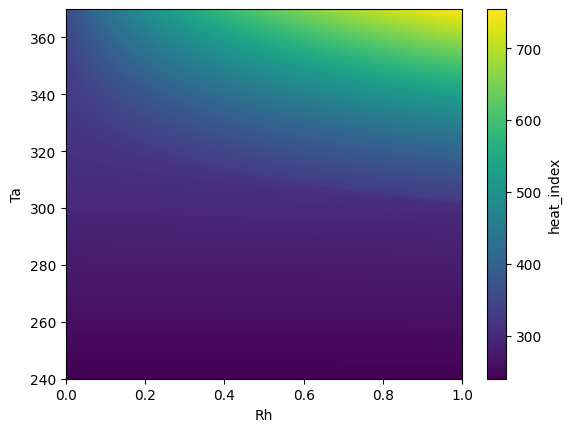

In [110]:
heat_index = xr.open_zarr("/pscratch/sd/a/amahesh/hens/prod_heat_index_lookup.zarr")
heat_index['heat_index'].plot()